In [2]:
from itertools import *
import numpy as np
import pandas as pd
import re
import os
import sys
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
words = set(nltk.corpus.words.words())
#!{sys.executable} -m pip install pyLDAvis
from stop_words import get_stop_words
from gensim import corpora, models
import gensim
import _pickle as cPickle
import joblib
import bz2
import pyLDAvis
import pyLDAvis.gensim_models

[nltk_data] Downloading package stopwords to /home/kbari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kbari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  

In [3]:
## Path to text files
path = "/home/kbari/git_repo/FinanceErdosProj/PyMuPdf_Text/"
path1 = "/home/kbari/git_repo/FinanceErdosProj/Tesseract_Text/"

## Load from txt from files to a dataframe; Other information to include possibly?

#pd.read_table(file,header=None,quotechar=None,quoting=3,error_bad_lines=False) for file in DIR]
def txt_to_df(path):
    ''' Put all txt files into single dataframe'''
    DIR = os.listdir(path)
    raw_df_lst = []
    for i in range(len(DIR)):
        with open(path+DIR[i],encoding = "ISO-8859-1") as f:
            lines = f.readlines()
            data = '\n'.join(map(str,lines))
            print(DIR[i])
            p = proj_desc_preprocess(data)
            if p is not None:
                p = p.replace("\n","")
                l = len(p)
            else:
                l = 0
            di= pd.DataFrame([data,p,int(l)],index=['raw_text','proj_desc','num_char'],columns=[DIR[i]]).T
            raw_df_lst.append(di)
    #print(len(raw_df_lst))
    df_raw = pd.concat(raw_df_lst)
    return df_raw

## Grab Project Description   
def proj_desc_preprocess(text):
    ''' Grab Project Description'''
    if len(re.findall('Project Description',text,re.IGNORECASE)) > 0:
        start = 'Project Description'
        end = 'SCHEDULE'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Description of the Project',text,re.IGNORECASE)) > 0:
        start = 'Description of the Project'
        end = 'SCHEDULE'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Program Actions',text,re.IGNORECASE)) > 0:
        start = 'Program Actions'
        end = 'Section II'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Schedule 3',text,re.IGNORECASE)) > 0:
        start = 'SCHEDULE 3'
        #end = 'SCHEDULE 3'
        try:
            return text.split(start)[1]
        except:
            return None
    elif len(re.findall('Schedule III',text,re.IGNORECASE)) > 0:
        start = 'SCHEDULE III'
        #end = 'SCHEDULE 3'
        try:
            return text.split(start)[1]
        except:
            return None
    else:
        print('CASE 4')
        return None


df = txt_to_df(path)
df1 = txt_to_df(path1)
dF = pd.concat([df,df1])
## Drop null proj desc
dG = dF.dropna()

2006_july_4_213051468296429321_loan-agreement-l4825-ro-conformed.txt
1996_december_13_893741468282540693_conformed-copy--l4113--public-finance-management-project--loan-agreement.txt
1994_september_30_745841468259144739_conformed-copy--l3792--land-administration-project--loan-agreement.txt
1990_june_22_418341468249703395_conformed-copy--l3188--housing-project--loan-agreement.txt
2009_june_11_345301468026058559_loan-agreement-l7686-cr-conformed.txt
1998_april_8_828001468332701640_conformed-copy--l4301--early-childhood-development-project--loan-agreement.txt
2007_april_16_917181468025771221_loan-agreement--l7434-co--conformed.txt
1997_june_25_702941468094153972_conformed-copy--l4203--social-protection-adjustment-loan--loan-agreement.txt
2011_december_13_303021468123575214_loan-agreement-for-loan-8004-mx-conformed.txt
1995_january_30_863491468145153420_conformed-copy--l3808--financial-sector-deepening-and-intermediation-project--loan-agreement.txt
1991_september_16_374721468231304302_confo

1997_may_2_658581468053683171_conformed-copy--l4137--community-forestry-project--loan-agreement.txt
2006_july_7_578511468109480557_loan-agreement-l7394-tr-conformed.txt
1994_february_14_142551468309289523_conformed-copy--l3679--private-investment-credit-project--loan-agreement-9.txt
2018_october_12_220221540311015427_official-documents-loan-agreement-for-additional-financing-loan-8836-co-closing-package.txt
1997_october_29_522761468249630410_conformed-copy--l4230--youth-training-project--loan-agreement.txt
1996_october_16_324011468299211363_conformed-copy--l4102--structural-adjustment-loan--loan-agreement.txt
2016_may_12_772721467992786799_official-documents-loan-agreement-for-loan-8615-am-closing-package.txt
1995_september_14_938621468057335985_philippines--second-rural-finance-project--currency-pool-loan-_-loan-3938--loan-agreement--conformed.txt
1990_september_27_694611468337267675_conformed-copy--l3179--forest-resources-management-and-development-project--loan-agreement.txt
1997_ap

2008_november_21_587951468270625702_second-additional-financing-for-loan-agreement,-l7592-mx-conformed.txt
2013_december_16_246261468040135600_official-documents-loan-agreement-for-loan-8317-jm-closing-package.txt
1990_april_5_790191468211457471_conformed-copy--l3076--west-mitidja-irrigation-project--loan-agreement.txt
2011_january_26_928001468005953010_loan-agreement-for-loan-7987-am-conformed.txt
2014_october_9_800601468305081068_official-documents-loan-agreement-for-loan-8439-sc-closing-package.txt
2018_may_8_932051525875091433_official-documents-loan-agreement-for-loan-8794-uy.txt
1994_june_2_205881468015290968_conformed-copy--l3711--shanghai-environment-project--loan-agreement.txt
2000_january_19_535251468286496915_conformed-copy--l4525--second-gazelle-restoration-project--loan-agreement.txt
2003_october_1_703751468034798163_conformed-copy--c3809--oecs-education-development-project--loan-agreement.txt
2012_june_5_735911468062964190_official-documents-loan-agreement-for-loan-8154-p

2009_september_18_897201468246048599_loan-agreement,-l7680-do-conformed.txt
1996_july_2_836891468175483553_conformed-copy--l4037--industry-support-institutions-upgrading-project--loan-agreement.txt
1990_march_16_762811468295511627_conformed-copy--l3164--energy-sector-project--pnoc-loan-agreement.txt
1990_april_24_668811468165272290_conformed-copy--c2120--water-supply-project--loan-agreement.txt
CASE 4
2002_may_29_327551468103760478_conformed-copy--l7098--social-benefits-reform-administration-project--loan-agreement.txt
2002_july_31_691591468092355908_conformed-copy--l4662--treasury-development-project--loan-agreement.txt
1998_june_29_919041468310488546_conformed-copy--l4357--transport-sector-project--loan-agreement.txt
2012_april_13_718721468224370578_official-documents-loan-agreement-for-loan-8142-br-closing-package.txt
1992_december_21_309161468296117590_conformed-copy--l3499--housing-project--loan-agreement.txt
1998_june_25_881211468272970744_conformed-copy--l4359--pension-reform-ad

2009_august_2_497521468026686025_loan-agreement-l7656-eg-railways-restructuring-conformed.txt
2008_june_20_302361468017970821_loan-agreement,-l7488-br-conformed.txt
2018_october_24_468671544545188555_official-documents-loan-agreement-for-loan-8861-id-closing-package.txt
2011_april_5_812551468172142707_loan-agreement-for-loan-8015-tr-conformed.txt
1992_june_3_681971468057893694_conformed-copy--l3439--rural-electrification-revitalization-project--loan-agreement.txt
2004_june_2_462751468016173722_loan-agremeent,-l4724-ch--zhejiang-urban-environment-project--conformed.txt
2000_march_7_571511468294098981_conformed-copy--l4528--regional-fiscal-technical-assistance-project--loan-agreement.txt
2003_february_7_256281468322792171_conformed-copy--l4661--support-for-the-social-development-agency-project--loan-agreement.txt
1990_may_7_597241468056655874_conformed-copy--l3132--second-highways-project--loan-agreement.txt
2002_september_26_729191468263718184_conformed-copy--l7123--urban-transport-deve

2017_may_12_681591497463996929_official-documents-loan-agreement-for-loan-8738-yf-closing-package.txt
2001_september_25_440461468294111758_conformed-copy--l7072--enterprise-and-financial-sector-adjustment-loan--loan-agreement.txt
2003_august_28_883181468251394647_conformed-copy--l4706--tamil-nadu-road-sector-project--loan-agreement.txt
2006_november_3_540561468068926739_loan-agreement-l7368-pe-conformed.txt
2007_june_29_619341468319137903_loan-agreement-l7469-tr-conformed.txt
1991_december_9_878011468233700064_conformed-copy--l3414--basic-education-rehabilitation-project--loan-agreement.txt
2001_july_3_408581469672166991_conformed-copy--l4613--court-and-bankruptcy-administration-project--loan-agreement.txt
2007_january_23_519471468058478280_loan-agreement-l7424-ph-conformed.txt
CASE 4
2014_april_30_498361468224697268_official-documents-loan-agreement,-l8327-br-closing-package.txt
1994_september_27_819981468294100608_conformed-copy--l3768--second-oil-rehabilitation-project--loan-agreeme

2015_may_28_748891468290960965_official-documents-loan-agreement-for-loan-8499-in-closing-package.txt
1995_august_31_526771468012944588_conformed-copy--l3910--inland-waterways-project--loan-agreement.txt
2006_july_18_539441468122372445_loan-agreement-l7397-tn-conformed.txt
1990_december_28_821301468240310549_conformed-copy--l3278--public-sector-reform-loan--loan-agreement.txt
2006_january_31_994551468007791073_loan-agreement-l7329-br-conformed.txt
2000_october_23_101721468003301772_conformed-copy--l7029--privatization-assistance-project--loan-agreement.txt
2010_july_21_376051489609974334_ctf-loan-agreement-for-tf096291-mx-conformed.txt
1995_august_30_789401468286469139_conformed-copy--l3934--economic-recovery-program-loan--loan-agreement.txt
1997_october_29_502801468297322554_conformed-copy--l4144--st.-petersburg-center-city-rehabilitation-project--loan-agreement.txt
2016_october_5_442691476380556576_official-documents-loan-agreement-for-loan-8643-me-closing-package.txt
2017_february_2

1995_february_28_514691468028135637_china--zhejiang-power-development-project-_-loan-3846--loan-agreement--conformed.txt
1993_june_14_821081468287375270_conformed-copy--l3618--land-development-project-for-low-income-families--kingdom--loan-agreement-4.txt
1995_november_27_689991468023403309_conformed-copy--c2672--irrigation-improvement-project--loan-agreement.txt
CASE 4
2007_november_2_572841468250518219_loan-agreement,-l4862-in-conformed.txt
CASE 4
2006_june_5_207881468261309319_loan-agreement-l7361-ec-conformed.txt
2015_december_29_765021468024243333_official-documents-loan-agreement-for-loan-8563-do-closing-package.txt
1991_november_7_684741488895737603_conformed-copy--l3398--southeast-coast-paralimni-sewerage-and-drainage-project--loan-agreement-2.txt
2014_may_30_805381468008988594_official-documents-loan-agreement-for-loan-8399-al-closing-package.txt
2002_december_30_229341468094155367_conformed-copy--l4680--second-tax-administration-modernization-project--loan-agreement.txt
1991_

1995_february_6_708341468058487818_conformed-copy--l3688--irrigated-areas-agricultural-services-project--loan-agreement.txt
1990_june_5_933681468053339710_conformed-copy--l3207--road-transport-and-telecommunications-sector-adjustment-loan--loan-agreement.txt
2001_september_10_704621468057234711_conformed-copy--l7064--community-development-project--loan-agreement.txt
2010_december_8_126991468287401096_agreement-for-loan-7979-mx-conformed.txt
2017_june_22_414691502900029707_official-documents-loan-agreement-for-loan-8755-in-closing-package.txt
2010_august_12_878541468035476212_loan-agreement-for-loan-7926-ge-conformed.txt
1996_may_22_629901468146676730_conformed-copy--l3990--bridge-rehabilitation-project--loan-agreement.txt
2007_june_21_681761468115750423_loan-agreement-l7445-uy-conformed.txt
2010_march_30_411891467992803909_loan-agreement-for-loan-7843-ar-conformed.txt
1999_september_29_273531468324875765_conformed-copy--l4426--lakhdar-watershed-management-pilot-project--loan-agreement.

1996_november_1_804821468176634080_conformed-copy--l4098--electricity-market-development-project--loan-agreement.txt
2004_january_30_273131468273647696_conformed-copy--l7135--judicial-modernization-project--loan-agreement.txt
2013_march_21_584611468237295236_official-documents-loan-agreement-for-loan-8126-cl-closing-package.txt
1992_july_17_233201468095974728_conformed-copy--l3466--health-services-development-project--loan-agreement.txt
1990_july_6_436671468042269159_conformed-copy--l3209--gas-utilization-project--loan-agreement.txt
2012_march_23_787251468092986329_official-documents-loan-agreement-for-loan-8030-mk-closing-package.txt
2005_july_14_921991468290694625_loan-agreement,-l4777-lc-conformed.txt
2014_october_22_679601468221990742_official-documents-loan-agreement-for-loan-8407-az-closing-package.txt
2011_november_1_314381468005953407_loan-agreement-for-loan-8106-am-conformed.txt
2012_november_30_761661468270595237_official-documents-loan-agreement,-l8216-mx-closing-package.txt

2010_june_24_911251468031160663_loan-agreement-for-loan-7874-gd-conformed.txt
2013_september_18_472931468217182722_official-documents-loan-agreement,-l8257-br-closing-package.txt
2009_may_20_440751468002959991_loan-agreement,-l7549-az-conformed.txt
2006_april_18_711931468202780168_loan-agreement-l7301-ar-conformed.txt
1990_november_8_384401468332700618_conformed-copy--l3263--earthquake-reconstruction-project--loan-agreement.txt
1990_february_7_484641468287378263_conformed-copy--l3136--industrial-finance-project--loan-agreement-7.txt
2007_september_13_272161468052166530_loan-agreement,-l4834-id-conformed.txt
2013_june_24_748101468013781184_official-documents-loan-agreement-for-loan-8281-by,-additional-financing-closing-package.txt
2017_november_28_903541513088780370_official-documents-loan-agreement-for-loan-8774-md-closing-package.txt
1993_september_14_706051468098364871_pakistan--public-sector-adjustment-loan-_-credit-2542--loan-agreement--conformed.txt
1997_july_21_274901468230104403

2009_november_6_646881468243264131_loan-agreement-for-l7781-co-conformed.txt
1994_june_21_216621468245376439_croatia--emergency-reconstruction-project-_-loan-3760--loan-agreement--conformed.txt
1991_july_19_590631468273633666_conformed-copy--l3330--health-technology-project--loan-agreement.txt
2016_november_9_325051486056531744_official-documents-loan-agreement-for-loan-8640-ba-closing-package.txt
2009_july_28_935521467995359752_loan-agreement-l7725-az-conformed.txt
1996_november_7_306511468287395648_conformed-copy--l4076--irrigation-subsector-project--loan-agreement.txt
2008_july_14_638531468290104964_loan-agreement,-l7565-pk-conformed.txt
2007_june_22_238581468338058917_loan-agreement-l7389-tr-and-l7462-tr-conformed.txt
1998_december_11_638101468332702921_conformed-copy--l4413--third-rural-finance-project--loan-agreement.txt
2013_july_26_928151468240575542_official-documents-loan-agreement,-l8262-cn-closing-package.txt
2000_june_16_301911468288305550_conformed-copy--l7021--goverance-

1995_november_21_629361468010501827_argentina--social-protection-project-_-loan-3957--loan-agreement--conformed.txt
1996_august_27_930191468297292838_conformed-copy--l4033--medical-equipment-project--loan-agreement.txt
1992_december_22_469071468235488922_conformed-copy--l3547--santa-catarina-state-highway-management-project--loan-agreement-1.txt
1990_october_30_387091468230120146_china--fourth-rural-credit-report-_-credit-2182--loan-agreement--conformed.txt
CASE 4
1993_april_28_482731468052748849_conformed-copy--l3583--power-sector-efficiency-improvement-project--loan-agreement.txt
2007_may_8_117141468223192480_loan-agreement-l4856-cn-conformed.txt
1998_june_26_761081468230105057_conformed-copy--l4329--guangzhou-city-center-transport-project--loan-agreement.txt
2004_march_28_972611468055481704_conformed-copy--l7206--integrated-irrigation-modernization-project--loan-agreement.txt
2009_june_30_574161468119939431_loan-agreement-l7717-tr-conformed.txt
1993_january_21_815141468042271369_con

1994_august_29_126151468257637187_conformed-copy--l3753--container-transport-logistics-project--loan-agreement.txt
2011_september_25_769851468043441959_agreement-for-loan-8084-jm-conformed.txt
2002_september_30_145891468266122173_conformed-copy--l7145--second-programmatic-structural-adjustment-loan--loan-agreement.txt
CASE 4
2007_november_30_556281468332966604_loan-agreement,-l4867-ru-conformed.txt
2000_august_10_472421468223191843_conformed-copy--l4570--yangtze-dike-strengthening-project--loan-agreement.txt
2014_april_10_762571468297541089_official-documents-loan-agreement,-l8344-ph-closing-package.txt
2009_october_28_473311468015669330_loan-agreement-for-l7662-br-conformed.txt
1994_july_5_810331468209349717_belize--second-power-development-project-_-loan-3776--loan-agreement--conformed.txt
1997_january_15_514851468041085824_conformed-copy--l4100--second-village-infrastructure-project--loan-agreement.txt
1990_june_29_129481468286469491_conformed-copy--l3154--third-telecommunications-p

1991_july_31_574861468246576122_conformed-copy--l3374--structural-adjustment-loan--loan-agreement-3.txt
CASE 4
2012_july_12_718511468019438852_official-documents-loan-agreement-for-loan-8170-cn-closing-package.txt
1991_may_9_830201468060534530_conformed-copy--l3283--port-sector-project--kingdom--loan-agreement-2.txt
2005_september_5_328221468110079945_loan-agreement-l4780-ua-conformed.txt
1998_december_18_125671468020643643_conformed-copy--l4356--tri-provincial-highway-project--loan-agreement.txt
1996_september_20_409811468094784008_conformed-copy--l4032--bielsko-biala-water-and-wastewater-project--loan-agreement.txt
2018_july_9_411021533223500391_official-documents-loan-agreement-for-loan-8838-lb-and-cff-grant-tf0a7880-closing-package.txt
2012_november_26_712431468007511384_official-documents-loan-agreement-for-loan-8187-br-closing-package.txt
1993_august_13_110551468261271734_conformed-copy--l3575--agricultural-sector-credit-project--loan-agreement.txt
2008_april_12_70141146825555135

1994_july_1_268061468056437799_conformed-copy--l3736--technical-assistance-to-enhance-competitiveness-project--loan-agreement.txt
1998_june_18_438671468281118525_conformed-copy--l4347--economic-recovery-and-social-sector-loan--loan-agreement.txt
1991_may_24_331221468007280348_conformed-copy--l3299--pilot-public-health-management-project--loan-agreement.txt
2001_january_17_185521468059712553_conformed-copy--l4573--sustainable-coastal-tourism-development-project--loan-agreement.txt
2004_june_11_427191468338059326_loan-agremeent,-l4737-tr--conformed.txt
2005_august_26_887351468048828597_loan-agreement-l4774-kz-conformed.txt
2018_november_20_861791545328142733_official-documents-loan-agreement-for-loan-8908-in-closing-package.txt
2002_january_18_326251468224081997_conformed-copy--l4617--liao-river-basin-project--loan-agreement.txt
2007_may_18_159441468032109159_loan-agreement-l7357-gt-conformed.txt
2010_november_19_374431468012051347_loan-agreement-for-loan-7971-by-conformed.txt
2019_novem

1991_may_7_374751468306855715_conformed-copy--l3234--third-highway-sector-project--loan-agreement-3234-yu.txt
1991_november_27_874101468288598269_conformed-copy--l3335--karachi-port-modernization-project--loan-agreement.txt
2008_may_27_862141468260951524_loan-agreement-l7546-do-conformed.txt
1993_december_3_533231468123871516_conformed-copy--l3664--fifth-water-supply-project--kingdom--loan-agreement-1.txt
2010_december_9_365541468215962221_loan-agreement-for-loan-7732-br-conformed.txt
2008_may_28_752761468312856582_loan-agreement,-l7539-tr-conformed.txt
1998_july_31_470981468230071027_conformed-copy--c3097--guangxi-urban-environment-project--loan-agreement.txt
CASE 4
1991_june_20_936781468260123642_conformed-copy--l3320--industrial-restructuring-project--loan-agreement.txt
1997_november_27_410781468295197585_conformed-copy--l4236--roads-ii-project--loan-agreement.txt
1996_november_14_569391468319542677_conformed-copy--l4103--agriculture-sector-adjustment-loan--loan-agreement.txt
1990_j

2005_october_4_255091468005698979_loan-agreement,-l7253-br-conformed.txt
1995_july_16_275271468201244314_conformed-copy--l3917--rural-poverty-alleviation-project--bahia--loan-agreement.txt
2001_october_29_528131468017398070_conformed-copy--l4626--rural-poverty-reduction-project--ceara--loan-agreement.txt
1991_october_25_564911468059709046_conformed-copy--l3403--agriculture-sector-investment-loan--loan-agreement.txt
2010_april_19_202621468017387702_loan-agreement-for-loan-7849-cn-conformed.txt
1992_may_18_430841468043746185_conformed-copy--l3448--primary-education-quality-improvement-project--loan-agreement.txt
2018_june_29_899521531342683670_official-documents-loan-agreement-for-development-policy-loan-8885-tn-closing-package.txt
1990_june_5_910361468086043431_conformed-copy--l3208--telecommunications-technical-assistance-project--loan-agreement.txt
2004_july_12_733961468287378545_loan-agreement-l7245-ma--conformed.txt
1995_may_25_473681468012003272_conformed-copy--c2709--fiscal-techni

2010_july_6_678791468308950328_loan-agreement-for-loan-7904-tr-conformed.txt
2017_december_21_327151515598834372_official-documents-loan-agreement-for-loan-8736-ar-closing-package.txt
2009_july_2_307221468095973483_loan-agreement,-l7733-pl-conformed.txt
2012_july_27_524811468279276822_official-documents-loan-agreement-for-loan-8182-ma-closing-package.txt
2004_october_11_631901468224996921_fourth-inland-waterways-project-l4728-cn-conformed.txt
1990_june_15_203121469672154938_conformed-copy--l3156--second-forestry-development-project--loan-agreement.txt
2016_april_29_773011468059362414_official-documents-loan-agreement-for-loan-8584-ph-closing-package.txt
2004_march_29_790701468059949662_conformed-copy--l4701--rainfed-agriculture-development-project--loan-agreement.txt
2015_september_28_397231468020708633_official-documents-loan-agreement-for-loan-8353-br-closing-package.txt
1990_june_15_954141468273920553_conformed-copy--l3171--health-sector-investment-project--loan-agreement.txt
2009_s

1994_december_19_321631468044109159_conformed-copy--l3817--agriculture-sector-adjustment-loan--loan-agreement.txt
2018_march_21_383751535571748680_official-documents-loan-agreement-for-loan-8832-yf-closing-package.txt
2016_march_28_389801468036837514_official-documents-loan-agreement-for-loan-8595-ge-closing-package.txt
2012_april_6_661061468303088629_official-documents-loan-agreement-for-loan-8146-tr-closing-package.txt
2018_march_8_521981522170921171_official-documents-loan-agreement-for-loan-8820-me-closing-package.txt
1992_june_17_638161468056431242_conformed-copy--l3465--agricultural-technology-project--loan-agreement.txt
1997_august_29_496091468310506074_conformed-copy--l4216--water-supply,-sanitation-and-health-project--loan-agreement.txt
1996_june_18_467691468101659780_conformed-copy--l4022--environment-project--air-pollution-abatement-program--loan-agreement-1.txt
1996_april_17_688391468213897720_conformed-copy--l3986--second-shaanxi-provincial-highway-project--loan-agreement.

2014_july_9_613721468334925708_official-documents-loan-agreement-for-loan-8404-ua-closing-package.txt
2010_july_23_891881468205473386_loan-agreement-for-loan-7936-am-conformed.txt
2007_march_30_570841468011127696_loan-agreement-l4852-cn-conformed.txt
1991_may_7_732861468304780251_conformed-copy--l3235--third-highway-sector-project--loan-agreement-3235-yu.txt
2017_june_27_395181504808900475_official-documents-loan-agreement-for-loan-8765-in-closing-package.txt
2019_june_5_418021560435942487_official-documents-loan-agreement-for-loan-8747-br-closing-package.txt
2019_november_26_275631574776718614_official-documents-loan-agreement-for-loan-8998-pk.txt
2000_october_10_253451468228281914_conformed-copy--l4566--second-beijing-environment-project--loan-agreement.txt
1993_march_5_792141468033352511_conformed-copy--c2449--renewable-resources-development-project--loan-agreement.txt
2013_october_2_991221468285595631_official-documents-loan-agreement-for-loan-8246-pe-closing-package.txt
2010_may_2

1993_august_13_407211468012051100_conformed-copy--l3640--institution-building-project--loan-agreement.txt
1990_april_30_410811468040573756_conformed-copy--l3180--rural-electrification-project--loan-agreement.txt
2016_october_21_564651479415349565_official-documents-loan-agreement-for-loan-8513-in-closing-package.txt
2009_september_18_706681468030572547_loan-agreement-for-loan-7741-ge--east-west-highway-improvement-3--conformed.txt
1996_may_30_172681468287376468_conformed-copy--l4010--second-sewerage-and-water-re-use-project--loan-agreement.txt
2006_june_23_218991468145745115_loan-agreement-l7384-pl-conformed.txt
2018_august_10_471711535400427355_official-documents-loan-agreement-for-additional-financing-loan-8844-mx-closing-package.txt
2007_august_7_619471468034864932_loan-agreement,-l4860-in-conformed.txt
2008_october_8_748261468015287831_loan-agreement,-l7551-cn-conformed.txt
2000_july_7_588981468094790608_conformed-copy--l4568--health-sector-reform-project--loan-agreement.txt
2002_o

1995_december_12_935821468333015377_conformed-copy--l3950--telecommunications-regulation-and-privatization-support-project--loan-agreement.txt
2006_november_21_793321468011425694_loan-agreement-l4812-cn-conformed.txt
1993_may_26_401191468041662148_conformed-copy--l3589--flores-earthquake-reconstruction-project--loan-agreement.txt
2016_february_23_511851468209671196_official-documents-loan-agreement,-loan-8572-am-closing-package.txt
2016_november_30_252651481729437958_official-documents-loan-agreement-for-loan-8653-tr-closing-package.txt
2009_june_9_256771468174540305_loan-agreement,-l7715-tr-conformed.txt
2008_february_13_705131468333573528_loan-agreement,-l7493-pa-conformed.txt
2003_june_18_767621468016766159_conformed-copy--l4703--district-heating-project--loan-agreement.txt
2010_august_31_894981468028860644_loan-agreement-for-loan-7881-cn-conformed.txt
2017_may_3_563511495041315751_official-documents-loan-agreement-for-loan-8742-ge-closing-package.txt
2003_may_23_930411468272995453_

2011_december_15_877691468015569688_agreement-for-loan-8074-br-conformed.txt
2018_july_5_186021526398238384_official-documents-loan-agreement-for-additional-financing-loan-8793-iq-closing-package.txt
1991_january_23_692111468057300727_conformed-copy--l3287--industrial-restructuring-project--loan-agreement.txt
2013_november_11_528351468246656628_official-documents-loan-agreement-for-loan-8285-ec-closing-package.txt
2014_august_26_843341468017428023_official-documents-loan-agreement-for-loan-8271-br-closing-package.txt
2003_july_24_884791468276867774_conformed-copy--l7166--cutural-heritage-and-urban-development-project--loan-agreement.txt
2002_december_6_661281468025802022_conformed-copy--l7144--early-childhood-education-project--loan-agreement.txt
2014_november_12_260281468322139923_official-documents-loan-agreement-for-loan-8417-vn-closing-package.txt
1998_november_20_508811468096558366_conformed-copy--l4410--public-policy-reform-adjustment-loan--loan-agreement.txt
2016_january_14_3462

2018_june_5_421031529501710207_official-documents-disbursement-and-financial-information-letter-for-loan-8850-al-closing-package.txt
CASE 4
2007_july_27_329361468103156344_loan-agreemwnt,-l7463-yf-conformed.txt
1995_april_25_144831468094152851_conformed-copy--l3853--tax-administration-modernization-project--loan-agreement.txt
1991_march_21_183671468253242140_conformed-copy--l3301--earthquake-recovery-project--loan-agreement.txt
1993_january_14_791211468015662701_conformed-copy--l3552--shanghai-port-restructuring-and-development-project--loan-agreement.txt
1995_june_13_550161468117540564_venezuela--inparques-project-_-loan-3902--loan-agreement--conformed.txt
1991_july_3_369791468145482393_conformed-copy--l3363--technical-assistance-and-critical-imports-project--loan-agreement.txt
1994_august_10_744611468056937495_conformed-copy--l3769--irrigation-rehabilitation-and-modernization-project--loan-agreement.txt
2010_november_18_794621468282932059_loan-agreement-for-loan-7940-id-conformed.txt

2006_march_2_500511468258316234_loan-agreement-l7359-eg-conformed.txt
2007_november_9_162061468318024761_loan-agreement,-l4868-ua-conformed.txt
1996_july_18_906211468284389343_conformed-copy--l4061--uzen-oil-field-rehabilitation-project--loan-agreement.txt
2006_june_5_194801468289233399_loan-agreement-l7379-pk-conformed.txt
1994_september_21_541811468309289800_conformed-copy--l3782--water-supply-and-sewerage-project--loan-agreement.txt
1991_april_29_620661468034157107_conformed-copy--l3313--human-resources-development-project--loan-agreement.txt
1998_october_7_324651468248080230_conformed-copy--l4346--international-trade-and-integration-project--loan-agreement.txt
2005_november_3_110071468238177593_loan-agreement-l4804-cn-conformed.txt
2018_june_28_669921531140731248_official-documents-loan-agreement-for-loan-8835-ao-closing-package.txt
1992_december_16_760141468045251729_conformed-copy--l3536--third-primary-and-secondary-education-sector-project--loan-agreement.txt
2006_march_13_28438

2019_july_29_100681564776273055_official-documents-loan-agreement-for-loan-8988-mx-closing-package.txt
1994_september_11_265101468105276153_latvia--enterprise-and-financial-sector-restructuring-project-_-loan-3795--loan-agreement--conformed.txt
1994_june_22_662741468295796991_russia--highway-rehabilitation-and-maintenance-project-_-loan-3706--loan-agreement--conformed.txt
2013_november_27_855381468101390630_official-documents-loan-agreement,-l8255-yf-closing-package.txt
1995_may_23_587431468269438409_indonesia--book-and-reading-development-project-_-loan-3887--loan-agreement--conformed.txt
2017_october_16_247031511195461813_official-documents-loan-agreement-for-loan-8776-in-closing-package.txt
2013_april_12_614191468268209187_official-documents-loan-agreement,-l8245-id-closing-package.txt
1995_may_2_409061468246619834_dominican-republic--irrigated-land-and-watershed-management-project-_-loan-3875--loan-agreement--conformed.txt
1995_august_29_292561468097189059_papua-new-guinea--economi

1994_june_7_410701468041433479_indonesia--semarang-surakarta-urban-development-project-_-loan-3749--loan-agreement--conformed.txt
2019_march_5_702331559154568160_official-documents-loan-agreement-for-loan-8923-in-closing-package.txt
1995_january_24_881801468056926864_mexico--financial-sector-technical-assistance-project-_-loan-3838--loan-agreement--2--conformed.txt
2014_july_9_973481468036832612_official-documents-loan-agreement-for-loan-8402-ge-closing-package.txt
1995_june_15_726181468282873956_indonesia--fourth-health-project-_-loan-3905--loan-agreement--conformed.txt
1994_june_14_767321468035336353_indonesia--integrated-swamps-development-project-_-loan-3755--loan-agreement--conformed.txt
1995_february_28_366121468024854153_china--sichuan-power-transmission-project-_-loan-3848--loan-agreement--conformed.txt
2012_october_11_563301468306258137_official-documents-loan-agreement-for-loan-8195-ua-closing-package.txt
2009_november_12_114131468252897942_loan-agreement-for-loan-7804-ge-con

1995_may_25_104281468302407011_uzbekistan--cotton-sub-sector-improvement-project-_-loan-3894--loan-agreement--conformed.txt
2014_october_14_175701468093560371_official-documents-ctf-loan-agreement-tf017646-closing-package.txt
1994_december_22_258821468015658811_chile--third-road-sector-project-_-loan-3833--loan-agreement--conformed.txt
2013_april_19_837281468056438613_official-documents-loan-agreement-for-loan-8248-mu-closing-package.txt
1998_may_29_806201468019740340_china--yangzhou-thermal-power-project-_-loan-3718--loan-agreement--2--conformed.txt
CASE 4
1994_september_15_404541468260637096_indonesia--land-administration-project-_-loan-3792--loan-agreement--conformed.txt
1994_december_22_168961468248656295_egypt--irrigation-improvement-project-_-loan-3832--loan-agreement--conformed.txt
CASE 4
1995_march_9_251361468333889746_russia--tax-adminsitration-modernization-project-_-loan-3853--loan-agreement--conformed.txt
1994_september_22_528171468170059891_thailand--second-gas-transmissio

1995_june_6_547281468045543435_lebanon--solid-waste-environmental-management-project-_-loan-3899--loan-agreement--conformed.txt
2019_july_22_400861565120830605_official-documents-loan-agreement-for-loan-8946-ec-closing-package.txt
2019_october_24_342391574201578264_official-documents-loan-agreement-for-loan-9007-ar-closing-package.txt
1995_july_6_583881468215358825_bulgaria--railway-rehabilitation-project-_-loan-3922--loan-agreement--conformed.txt
2019_april_22_828481556814821022_official-documents-loan-agreement-for-scf-loan-tf0a8336-closing-package.txt
2013_april_20_723151468147287906_official-documents-loan-agreement,-l8238-ph-closing-package.txt
1993_december_21_133961468299950776_morocco--services-project-_-loan-3688--loan-agreement--conformed.txt
2019_december_10_701581579789087668_official-documents-loan-agreement-for-additional-financing-loan-8913-do-closing-package.txt
1995_january_31_347191468302943938_tunisia--rural-roads-project-_-loan-3840--loan-agreement--conformed.txt
19

In [4]:
tokenizer = RegexpTokenizer(r'\w+')
en_stop = get_stop_words('en')
p_stemmer = PorterStemmer()

def text_preprocess(text):
    tokens = tokenizer.tokenize(text.lower())
    t = [i for i in tokens if not i in en_stop]	
    t1 = [p_stemmer.stem(i) for i in t]
    return t1


### Removes punctuation, stopwords, lemmatizes
#def text_preprocess(text):
#    '''
#    Remove all punctuation,stopwords, lemmatize -> returns list of words
#    '''
#    stemmer = WordNetLemmatizer()
#    nopunc = [char for char in text if char not in string.punctuation]
#    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
#    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
#    nopunc = [w for w in nopunc if w.lower() in words or not w.isalpha()]
#    return [stemmer.lemmatize(word) for word in nopunc]

T = [ text_preprocess(t) for t in dG.proj_desc]

In [5]:
len(T)

2941

In [5]:
## Removes punctuation, stopwords, lemmatizes
def text_preprocess(text):
    '''
    Remove all punctuation,stopwords, lemmatize -> returns list of words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word for word in nopunc.split() if word.isalnum()]
    nopunc =  [word.lower() for word in nopunc if word not in stopwords.words('english')]
    nopunc =  [word for word in nopunc if len(word)>2]
    nopunc = [word for word in nopunc if word not in ['section','id','the','payment','objective','improvement','provision','bank','project','system','program','sector','time','loan','development','shall','set','forth','agreement','general','improve','improvement','down','strengthening']]
    nopunc = [w for w in nopunc if w.lower() in words or not w.isalpha()]
    return [stemmer.lemmatize(word) for word in nopunc]

In [6]:
docLabels= dG.index
data = dG.proj_desc

In [7]:
i = 2842
print(data[i])
print(text_preprocess(data[i]))

The objective of the Project is to improve access to affordable housing for Lower IncomeHouseholds.Part 1.(a)(b)Part 2.(a)(b)(c)The Project consists of the following parts:Mortgage-Linked Down Payment AssistanceMortgage-Linked Down Payment Assistance (BP2BT). Provision of mortgage-linked downpayment assistance for Lower Income Households, which are first time home-owners, throughParticipating Lending Institutions, for the purchase or construction of a residential property.Technical Assistance for Mortgage-Linked Down Payment Assistance. Provision of technicalassistance for: (1) developing and strengthening BP2BT management, administrative andinformation technology systems and capacities; (11) supporting BP2BT operations and thedevelopment of a rigorous monitoring and evaluation methodology and system, including abaseline study; (111) developing consumer financial literacy around BP2BT; (iv) developing aBP2BT public information campaign; and (v) developing and strengthening the lendingc

In [9]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))


def lem_stem(df):
    df['stem'] = list(map(lambda sentence: text_preprocess(sentence),df.proj_desc))
    
lem_stem(dG)

<ipython-input-9-06a6182263bb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stem'] = list(map(lambda sentence: text_preprocess(sentence),df.proj_desc))


In [13]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stem))
    
document_to_bow(dG)

<ipython-input-13-9a8c275029c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stem))


In [14]:
dG.head()

,raw_text,proj_desc,num_char,stem,bow
2006_july_4_213051468296429321_loan-agreement-l4825-ro-conformed.txt,CONFORMED COPY \n\n \n\nLOAN NUMBER 4825 RO \n...,The objective of the Project is to improve t...,4396,"[living, social, inclusion, vulnerable, people...","[(0, 1), (1, 1), (2, 1), (3, 4), (4, 2), (5, 4..."
1996_december_13_893741468282540693_conformed-copy--l4113--public-finance-management-project--loan-agreement.txt,...,The objective of the Project is to assist...,5056,"[assist, borrower, deployment, use, financial,...","[(3, 4), (7, 1), (34, 1), (35, 1), (36, 7), (4..."
1994_september_30_745841468259144739_conformed-copy--l3792--land-administration-project--loan-agreement.txt,...,The objectives of the Project are: (i) to ...,4251,"[foster, efficient, alleviate, social, land, l...","[(3, 5), (6, 1), (9, 9), (16, 1), (18, 1), (36..."
2009_june_11_345301468026058559_loan-agreement-l7686-cr-conformed.txt,\n\nCONFORMED COPY \n\n \n\n \n\n \n\n \n\n ...,; Availability of Loan Proceeds Section I. Ac...,5953,"[availability, proceeds, taken, under, taken, ...","[(9, 1), (22, 4), (35, 1), (36, 1), (37, 5), (..."
1998_april_8_828001468332701640_conformed-copy--l4301--early-childhood-development-project--loan-agreement.txt,CONFORMED COPY\n\nLOAN NUMBER 4301 PH\n\nLoan ...,The objective of the Project is to support the...,6192,"[support, national, early, borrower, national,...","[(3, 2), (5, 1), (7, 5), (8, 1), (9, 2), (10, ..."


In [11]:
dictionary = Dictionary(documents=dG.stem.values)

print("Found {} words.".format(len(dictionary.values())))

Found 7548 words.


In [12]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 4313 words.


In [15]:
corpus = dG.bow

In [16]:
%%time
num_topics = 11
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

CPU times: user 22.9 s, sys: 1.15 s, total: 24 s
Wall time: 23.3 s


In [17]:
LDAmodel.print_topics()

[(0,
  '0.056*"water" + 0.031*"management" + 0.015*"capacity" + 0.015*"environmental" + 0.014*"supply" + 0.013*"technical" + 0.012*"carrying" + 0.012*"part" + 0.012*"implementation" + 0.011*"construction"'),
 (1,
  '0.038*"health" + 0.022*"borrower" + 0.021*"public" + 0.015*"management" + 0.012*"implementation" + 0.012*"care" + 0.010*"social" + 0.009*"information" + 0.009*"financial" + 0.009*"national"'),
 (2,
  '0.050*"borrower" + 0.026*"law" + 0.013*"satisfactory" + 0.010*"public" + 0.010*"budget" + 0.009*"plan" + 0.009*"taken" + 0.008*"national" + 0.008*"financial" + 0.008*"adopted"'),
 (3,
  '0.028*"training" + 0.026*"management" + 0.015*"information" + 0.015*"research" + 0.014*"support" + 0.014*"implementation" + 0.013*"capacity" + 0.013*"technical" + 0.012*"technology" + 0.012*"carrying"'),
 (4,
  '0.026*"management" + 0.025*"construction" + 0.017*"equipment" + 0.015*"power" + 0.014*"training" + 0.013*"waste" + 0.013*"carrying" + 0.012*"borrower" + 0.011*"capacity" + 0.010*"rehab

In [ ]:
tokenized_only_dict = Counter(np.concatenate(dG.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [ ]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

In [ ]:
dictionary = Dictionary(documents=dG.stemmed_text.values)

In [ ]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

cleansed_words_df.sort_values('count', ascending=False, inplace=True)

In [6]:
document_lengths = np.array(list(map(len, dG.proj_desc.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 580.2393743624617.
The minimum number of words in a document is: 19.
The maximum number of words in a document is: 6603.


/home/kbari/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


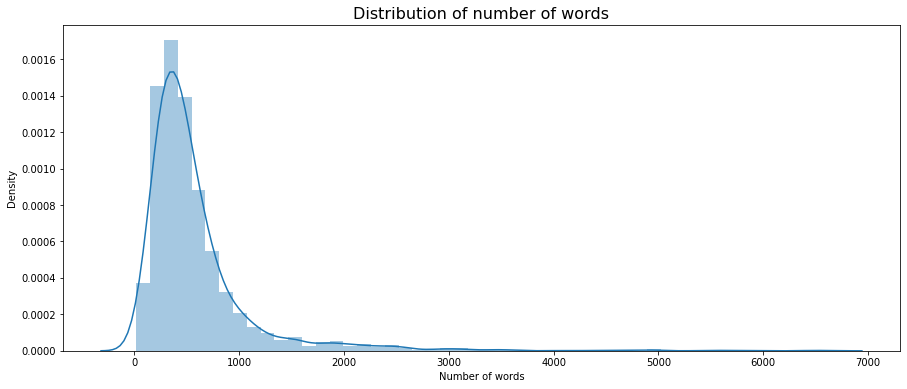

In [9]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

In [11]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [17]:
def lda_get_good_tokens(df):
    df['text'] = df.proj_desc.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.proj_desc))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(dG)

<ipython-input-17-ffc2f864ec78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df.proj_desc.str.lower()
<ipython-input-17-ffc2f864ec78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_text'] = list(map(nltk.word_tokenize, df.proj_desc))
<ipython-input-17-ffc2f864ec78>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [20]:
tokenized_only_dict = Counter(np.concatenate(dG.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [21]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

/home/kbari/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


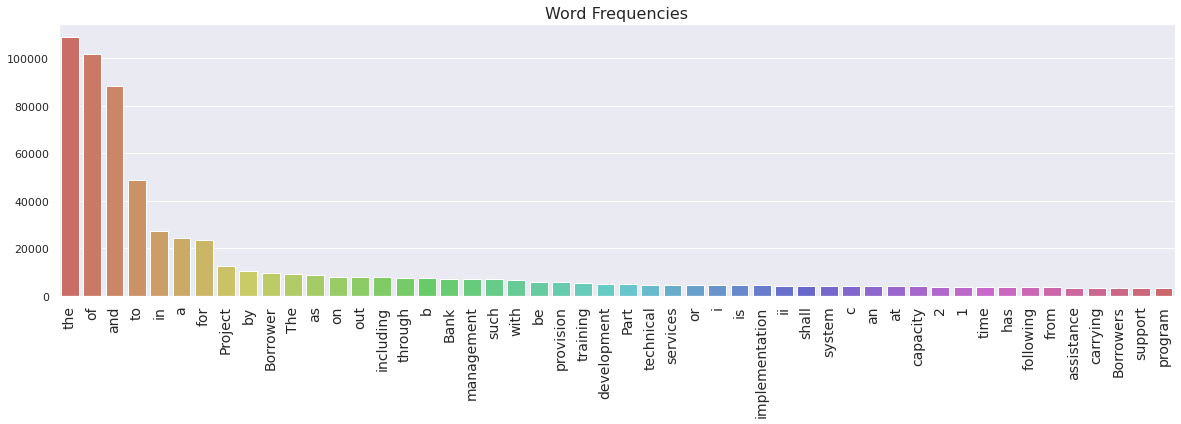

In [22]:
# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

In [24]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append('the')

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(dG)


def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(dG)

<ipython-input-24-4572f8517d41>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stopwords_removed'] = list(map(lambda doc:
<ipython-input-24-4572f8517d41>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_text'] = list(map(lambda sentence:
<ipython-input-24-4572f8517d41>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [26]:
dictionary = Dictionary(documents=dG.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 63097 words.


In [27]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 11831 words.


In [29]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(dG)

<ipython-input-29-823bf84db414>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))


In [30]:
# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

In [31]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

cleansed_words_df.sort_values('count', ascending=False, inplace=True)

/home/kbari/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


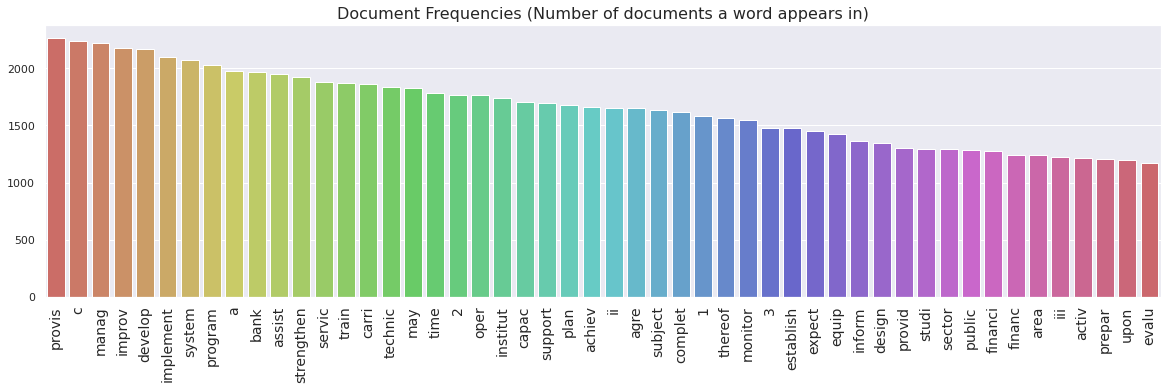

In [32]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

In [ ]:
### LDA TRAINING

In [61]:
print(dG.columns)
print(dG.bow[0])
dG.head()

Index(['raw_text', 'proj_desc', 'num_char', 'text', 'tokenized_text',
       'stopwords_removed', 'lemmatized_text', 'stemmed_text', 'bow',
       'lda_features', 'stem'],
      dtype='object')
[(6, 1), (21, 3), (24, 1), (25, 1), (34, 1), (35, 1), (43, 1), (44, 1), (49, 3), (55, 3), (59, 1), (61, 1), (65, 1), (79, 1), (81, 2), (90, 2), (91, 1), (92, 1), (95, 1), (102, 2), (106, 3), (111, 2), (115, 1), (119, 3), (124, 5), (128, 7), (133, 1), (136, 3), (137, 4), (140, 1), (145, 4), (6622, 7)]


,raw_text,proj_desc,num_char,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,lda_features,stem
2006_july_4_213051468296429321_loan-agreement-l4825-ro-conformed.txt,CONFORMED COPY \n\n \n\nLOAN NUMBER 4825 RO \n...,The objective of the Project is to improve t...,4396,the objective of the project is to improve t...,"[The, objective, of, the, Project, is, to, imp...","[The, objective, Project, improve, living, con...","[The, objective, Project, improve, living, con...","[the, object, project, improv, live, condit, s...","[(6, 1), (21, 3), (24, 1), (25, 1), (34, 1), (...","[0.0005469204625114799, 0.000416327704442665, ...","[improve, living, social, inclusion, vulnerabl..."
1996_december_13_893741468282540693_conformed-copy--l4113--public-finance-management-project--loan-agreement.txt,...,The objective of the Project is to assist...,5056,the objective of the project is to assist...,"[The, objective, of, the, Project, is, to, ass...","[The, objective, Project, assist, Borrower, op...","[The, objective, Project, assist, Borrower, op...","[the, object, project, assist, borrow, optimiz...","[(12, 3), (54, 1), (65, 1), (91, 1), (92, 1), ...","[0.0006035654223524034, 0.0004572453035507351,...","[assist, borrower, deployment, use, financial,..."
1994_september_30_745841468259144739_conformed-copy--l3792--land-administration-project--loan-agreement.txt,...,The objectives of the Project are: (i) to ...,4251,the objectives of the project are: (i) to ...,"[The, objectives, of, the, Project, are, i, to...","[The, objectives, Project, foster, efficient, ...","[The, objective, Project, foster, efficient, e...","[the, object, project, foster, effici, equitab...","[(35, 1), (81, 3), (111, 2), (124, 1), (128, 3...","[0.0006530506070703268, 0.0004961146623827517,...","[foster, efficient, alleviate, social, land, l..."
2009_june_11_345301468026058559_loan-agreement-l7686-cr-conformed.txt,\n\nCONFORMED COPY \n\n \n\n \n\n \n\n \n\n ...,; Availability of Loan Proceeds Section I. Ac...,5953,; availability of loan proceeds section i. ac...,"[Availability, of, Loan, Proceeds, Section, I,...","[Availability, Loan, Proceeds, Section, I, Act...","[Availability, Loan, Proceeds, Section, I, Act...","[avail, loan, proce, section, i, action, taken...","[(61, 1), (65, 1), (92, 1), (105, 1), (106, 7)...","[0.00038221394061110914, 0.0002907814341597259...","[availability, loan, proceeds, section, i, tak..."
1998_april_8_828001468332701640_conformed-copy--l4301--early-childhood-development-project--loan-agreement.txt,CONFORMED COPY\n\nLOAN NUMBER 4301 PH\n\nLoan ...,The objective of the Project is to support the...,6192,the objective of the project is to support the...,"[The, objective, of, the, Project, is, to, sup...","[The, objective, Project, support, Borrowers, ...","[The, objective, Project, support, Borrowers, ...","[the, object, project, support, borrow, tenyea...","[(21, 1), (24, 8), (25, 15), (34, 2), (35, 1),...","[0.0004246555909048766, 0.0003233730385545641,...","[support, national, early, borrower, national,..."


In [89]:
corpus = dG.bow

In [90]:
%%time
num_topics = 11
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

CPU times: user 21 s, sys: 786 ms, total: 21.8 s
Wall time: 21.5 s


In [39]:
def document_to_lda_features(lda_model, document):
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

dG['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      dG.bow))

<ipython-input-39-39c4aae6c6c3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dG['lda_features'] = list(map(lambda doc:


In [40]:
dG.lda_features[0]

array([5.46920463e-04, 4.16327704e-04, 3.36649333e-04, 2.83102505e-04,
       2.22093835e-02, 2.14965898e-04, 1.91891333e-04, 1.73290871e-04,
       1.57977876e-04, 9.75335300e-01, 1.34251444e-04])

In [41]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [91]:
LDAmodel.print_topics()

[(0,
  '0.057*"support" + 0.035*"inter" + 0.026*"rural" + 0.020*"public" + 0.017*"design" + 0.017*"data" + 0.016*"good" + 0.016*"staff" + 0.015*"national" + 0.015*"access"'),
 (1,
  '0.059*"year" + 0.037*"agreement" + 0.022*"to" + 0.017*"least" + 0.016*"forth" + 0.015*"may" + 0.015*"per" + 0.014*"calendar" + 0.014*"plan" + 0.013*"in"'),
 (2,
  '0.047*"social" + 0.034*"support" + 0.028*"design" + 0.026*"local" + 0.023*"school" + 0.020*"staff" + 0.019*"may" + 0.018*"subject" + 0.017*"thereof" + 0.016*"public"'),
 (3,
  '0.093*"health" + 0.038*"national" + 0.037*"research" + 0.022*"public" + 0.019*"law" + 0.017*"no" + 0.013*"care" + 0.013*"support" + 0.012*"staff" + 0.011*"social"'),
 (4,
  '0.079*"date" + 0.050*"amount" + 0.048*"shall" + 0.032*"agreement" + 0.027*"paragraph" + 0.027*"withdrawn" + 0.018*"forth" + 0.018*"set" + 0.017*"may" + 0.016*"no"'),
 (5,
  '0.130*"forest" + 0.033*"staff" + 0.022*"research" + 0.021*"ha" + 0.015*"timber" + 0.012*"small" + 0.012*"wood" + 0.011*"east" + 

In [15]:
#dictionary = corpora.Dictionary(T)
#corpus = [dictionary.doc2bow(text) for text in T]
#lda = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=dictionary, 
                                              num_topics=200, chunksize=1000, passes=20, workers=30)


#tokens_after_lemmas_and_rm_stopwords = open('tokens_after_lemmas_and_rm_stopwords.txt', 'w')
#for item in texts:
#    tokens_after_lemmas_and_rm_stopwords.write("%s\n" % item)
    
#dictionary.save_as_text('lemmas_nostopwords_with_otherdatacleaning_dictionary_' + sys.argv[2] + '.txt')

#corpora.MmCorpus.serialize('lemmas_nostopwords_corpus_'+ sys.argv[2] +'.mm', corpus)
    
#joblib.dump(lda, 'ldamodel_'+ sys.argv[2]+ '.pkl')

Process ForkPoolWorker-66:
Process ForkPoolWorker-84:
Process ForkPoolWorker-61:
Process ForkPoolWorker-85:
Process ForkPoolWorker-90:
Process ForkPoolWorker-83:
Process ForkPoolWorker-82:
Process ForkPoolWorker-68:
Process ForkPoolWorker-70:
Process ForkPoolWorker-69:
Process ForkPoolWorker-87:
Process ForkPoolWorker-86:
Process ForkPoolWorker-65:
Process ForkPoolWorker-67:
Process ForkPoolWorker-89:
Process ForkPoolWorker-88:
Process ForkPoolWorker-71:
Process ForkPoolWorker-62:
Process ForkPoolWorker-63:
Process ForkPoolWorker-76:
Traceback (most recent call last):
Process ForkPoolWorker-64:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkP

  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kbari/.local/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 341, in worker_e_step
    chunk_no, chunk, w_state = input_queue.get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/kbari/.local/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 341, in worker_e_step
    chunk_no, chunk, w_state = input_queue.get()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/kbari/.local/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 341, in worker_e_step
    chunk_no, chunk, w_state = input_queue.get

  File "/home/kbari/.local/lib/python3.8/site-packages/gensim/models/ldamulticore.py", line 341, in worker_e_step
    chunk_no, chunk, w_state = input_queue.get()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 96, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/home/kbari/.local/lib/python3.8/site-packages/gensim/models

KeyboardInterrupt: 

  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 96, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 96, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/kbari/.local/lib/python3.8/site-packages/gensim/models/ldamulticore.